In [1]:
! pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 24.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=73b254eb807f030cad818ca2711523c4f9cf954ccde94f98a6a24ee5b6fa2ca5
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from langdetect import detect
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
data = pd.read_csv('/kaggle/input/british-airways-reviews/British_Airways_reviews.csv')
data = data.drop(columns = 'Unnamed: 0')

# Basic Check

In [4]:
data.head(5)

,Seat_Type,Recomend_to_others,Review_heading,review_content
0,Premium Economy,no,“Staff look tired and overworked”,Not Verified | Overall not bad. Staff look ti...
1,Business Class,yes,“I couldn’t fault them”,✅ Trip Verified | This was our first flight wi...
2,Economy Class,no,“incompetence in customer service”,✅ Trip Verified | I recently encountered a hig...
3,Premium Economy,no,“The most ridiculous thing I've heard”,Not Verified | Beware! BA don't provide any r...
4,Business Class,yes,"""one of the most disgusting onboard meals""",✅ Trip Verified | Check in was chaotic and ba...


In [5]:
data.isnull().mean()

Seat_Type             0.0
Recomend_to_others    0.0
Review_heading        0.0
review_content        0.0
dtype: float64

In [6]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"


detected_lang = data['review_content'].apply(detect_language)


In [7]:
detected_lang.unique()

array(['en'], dtype=object)

# Basic Plot

In [8]:
tmp = data[['Seat_Type','Recomend_to_others']]
tmp.nunique()

Seat_Type             3
Recomend_to_others    2
dtype: int64

In [9]:
def prop_plot_pie(df, cols):
    sns.set_style("darkgrid")
    cmap = plt.get_cmap("YlOrRd")

    for col in cols:
        counts = df[col].value_counts()
        labels = counts.index
        sizes = counts.values
        
        
        largest_idx = np.argmax(sizes)
        
      
        colors = [cmap(i / len(labels)) for i in range(len(labels))]
        colors[largest_idx] = "gold"  

        plt.figure(figsize=(6, 4))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,
                colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth': 1})
        plt.title(f"Proportion of {col} in Dataset", fontsize=14)
        plt.show()

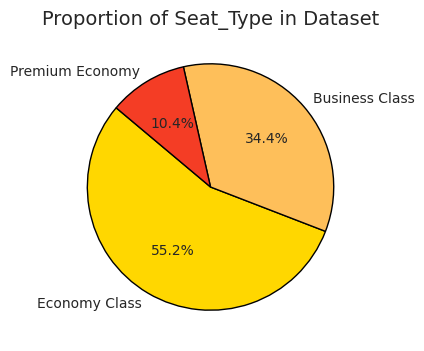

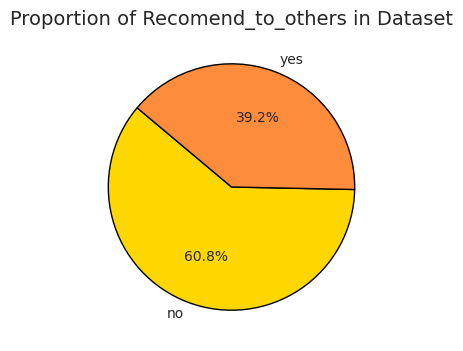

In [10]:
prop_plot_pie(tmp,tmp.columns)

# Engineering

In [11]:
data['Verified'] = (data['review_content'].str.contains('Trip Verified', na=False)).astype(int)
data['Not Verified'] = (data['review_content'].str.contains('Not Verified', na=False)).astype(int)
data['Unknown'] = (~data['review_content'].str.contains('Not Verified|Trip Verified', na=False)).astype(int)

data['Checked_trip'] = np.select(
    [
        data['Verified'] == 1,
        data['Not Verified'] == 1,
        data['Unknown'] == 1
    ],
    [
        'Verified',
        'Not Verified',
        'Unknown'
    ],
    default='Unknown'
)
data['Raw_review'] = data['review_content'].str.replace(r'(Not Verified \|)|(✅ Trip Verified \|)', '', regex=True).str.strip()
data = data.drop(columns = 'review_content')

data['title_lgt'] = data['Review_heading'].apply(len)
data['text_lgt'] = data['Raw_review'].apply(len)

title_stat = data['title_lgt'].describe()
text_stat = data['text_lgt'].describe()



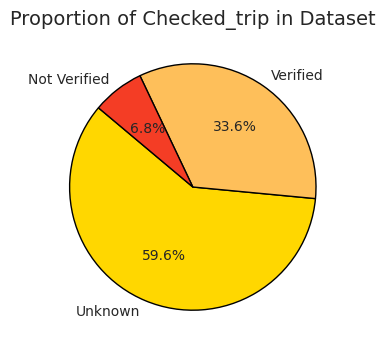

In [12]:
prop_plot_pie(data,['Checked_trip'])


##############################

Title Length Statistics: 

 count    3486.000000
mean       30.392140
std         6.242561
min        12.000000
25%        27.000000
50%        31.000000
75%        32.000000
max        81.000000
Name: title_lgt, dtype: float64

##############################



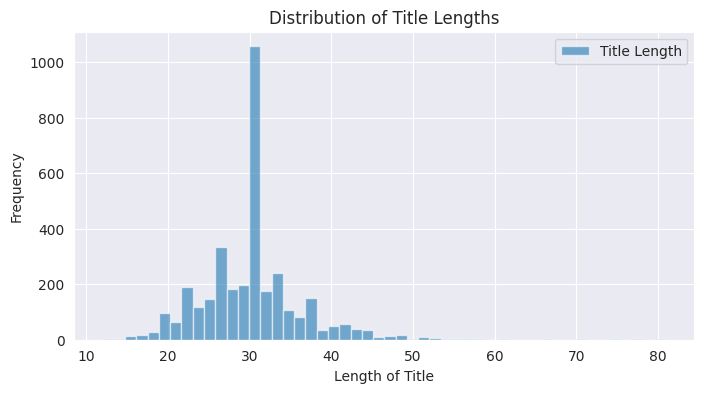

In [13]:
print('\n##############################\n')
print("Title Length Statistics: \n\n", title_stat)
print('\n##############################\n')

plt.figure(figsize=(8, 4))
plt.hist(data['title_lgt'], bins=50, alpha=0.6, label='Title Length')
plt.xlabel('Length of Title')
plt.ylabel('Frequency')
plt.title('Distribution of Title Lengths')
plt.legend()
plt.show()


##############################

Text Length Statistics: 

 count    3486.000000
mean      896.423408
std       579.584405
min        83.000000
25%       486.000000
50%       751.500000
75%      1133.000000
max      3537.000000
Name: text_lgt, dtype: float64

##############################



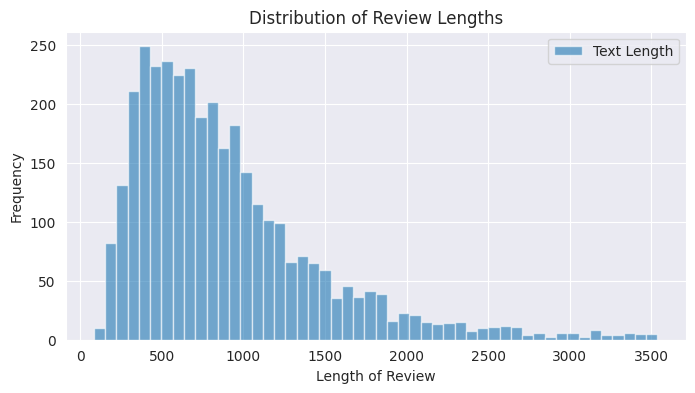

In [14]:
print('\n##############################\n')
print("Text Length Statistics: \n\n", text_stat)
print('\n##############################\n')

plt.figure(figsize=(8, 4))
plt.hist(data['text_lgt'], bins=50, alpha=0.6, label='Text Length')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.legend()
plt.show()

# Words EDA 

In [15]:
stop_words = stopwords.words('english')
def clean_text(text):
    words = text.lower().split()
    return [word for word in words if word not in stop_words]




data['cleaned_text'] = data['Raw_review'].apply(lambda x: ' '.join(clean_text(x)))
data['cleaned_text_lgt'] = data['cleaned_text'].apply(lambda x: len(x.split()))


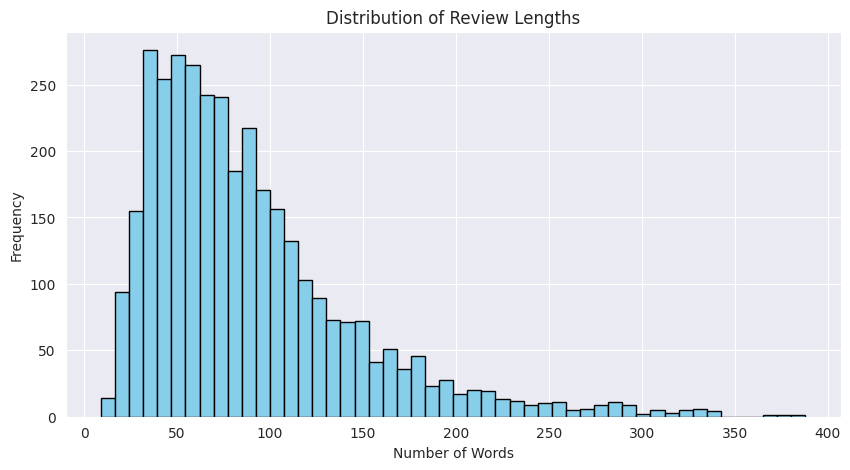

In [16]:
plt.figure(figsize=(10, 5))
plt.hist(data['cleaned_text_lgt'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

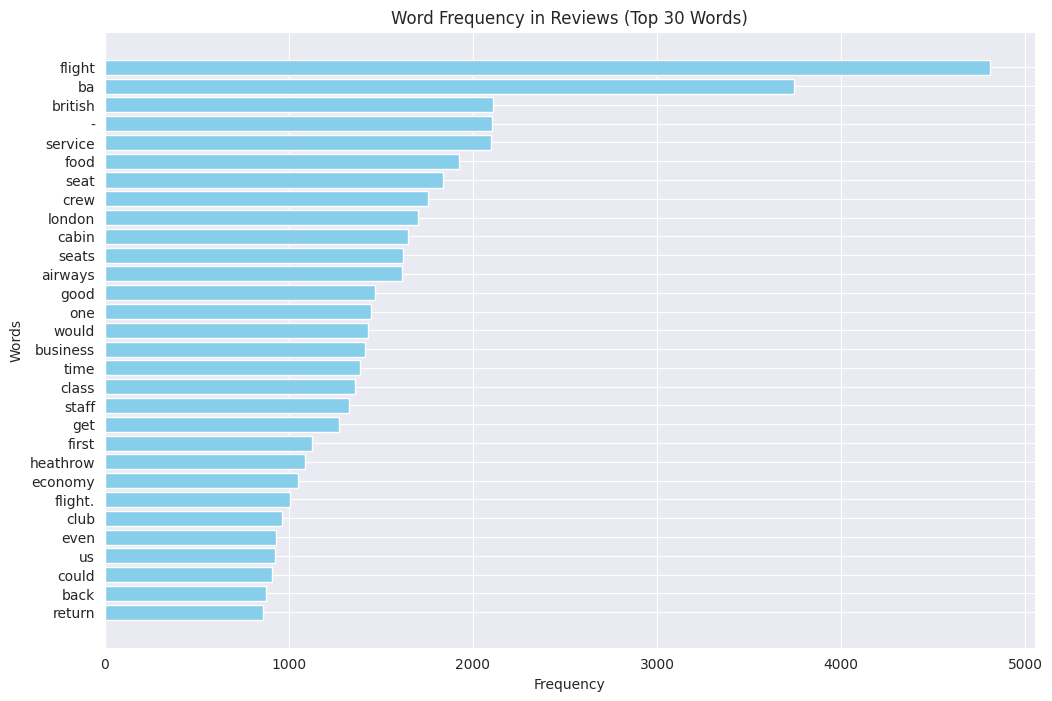

In [17]:
all_words = ' '.join(data['cleaned_text']).split()
word_counts = Counter(all_words)


word_freq = word_counts.most_common(30)

word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

words, freq = zip(*word_freq)

# Plot the bar chart
plt.figure(figsize=(12, 8))
plt.barh(words, freq, color='skyblue')
plt.gca().invert_yaxis()  
plt.title('Word Frequency in Reviews (Top 30 Words)')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

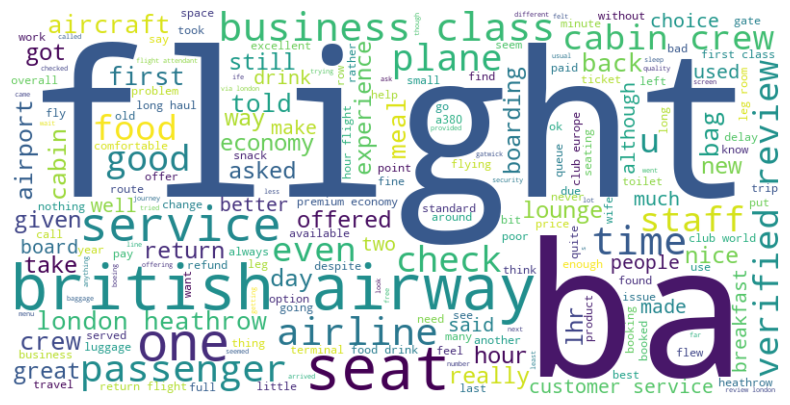

In [18]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
def compute_coherence_values(vectorizer, data_vectorized, start, stop, step):
    coherence_values = []
    for n_topics in range(start, stop, step):
        lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda_model.fit(data_vectorized)
        coherence_values.append(lda_model.score(data_vectorized))
        
    
    x = range(start, stop, step)
    plt.plot(x, coherence_values, marker='o')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Score for Different Number of Topics")
    plt.show()

def compute_perplexity_values(vectorizer, data_vectorized, start, stop, step):
    perplexity_values = []
    for n_topics in range(start, stop, step):
        lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda_model.fit(data_vectorized)
        perplexity_values.append(lda_model.perplexity(data_vectorized))

    x = range(start, stop, step)
    plt.plot(x, perplexity_values, marker='o', color='red')
    plt.xlabel("Number of Topics")
    plt.ylabel("Perplexity")
    plt.title("Perplexity Score for Different Number of Topics")
    plt.show()

    
def plot_bigram(x,y):
    plt.figure(figsize=(12, 6))
    plt.barh(x, y, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title('Top 20 Most Frequent Bigrams')
    plt.xlabel('Count')
    plt.show()

## Bigram&Trigram

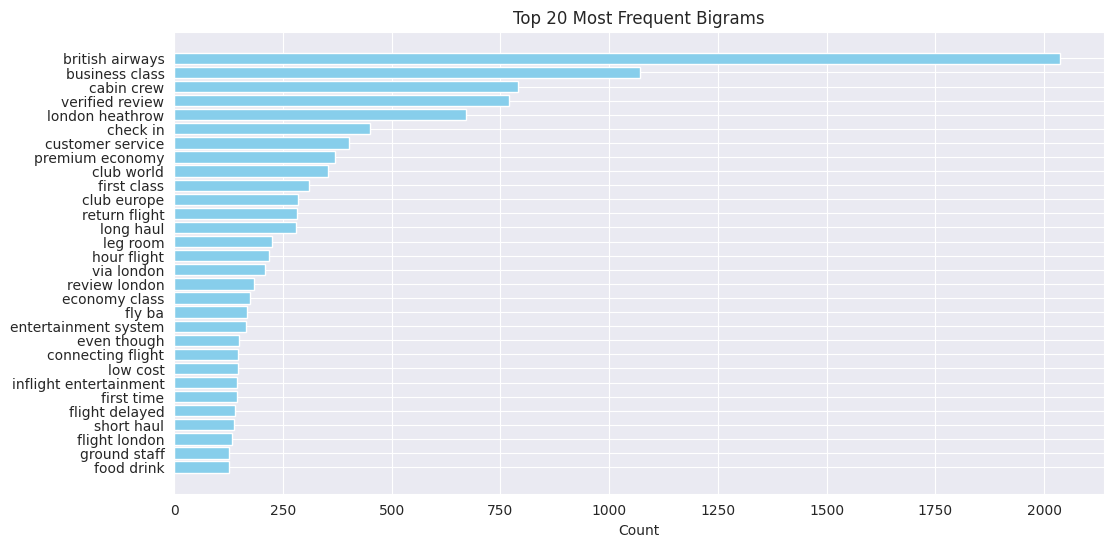

In [20]:
# Bigram
count_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=500)
count_matrix = count_vectorizer.fit_transform(data['cleaned_text'])


count_features = count_vectorizer.get_feature_names_out()
count_scores = count_matrix.sum(axis=0).A1

count_df = pd.DataFrame({'bigram': count_features, 'count': count_scores})
count_df = count_df.sort_values(by='count', ascending=False).head(30).reset_index(drop = True)

plot_bigram(count_df['bigram'],count_df['count'])

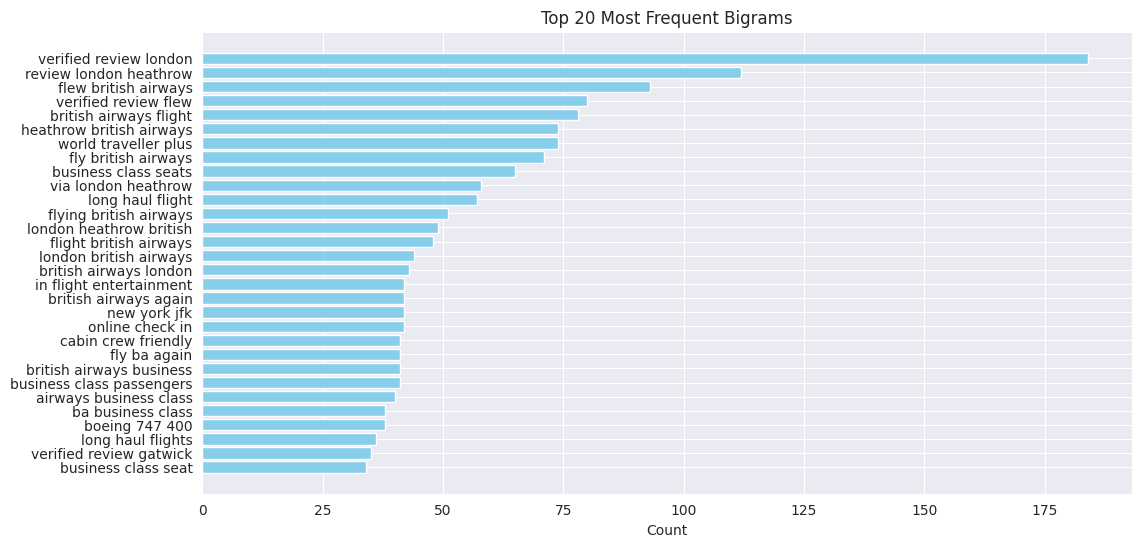

In [21]:
# Trigram
count_vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=500)
count_matrix = count_vectorizer.fit_transform(data['cleaned_text'])


count_features = count_vectorizer.get_feature_names_out()
count_scores = count_matrix.sum(axis=0).A1

count_df = pd.DataFrame({'trigram': count_features, 'count': count_scores})
count_df = count_df.sort_values(by='count', ascending=False).head(30).reset_index(drop = True)

plot_bigram(count_df['trigram'],count_df['count'])

## LDA

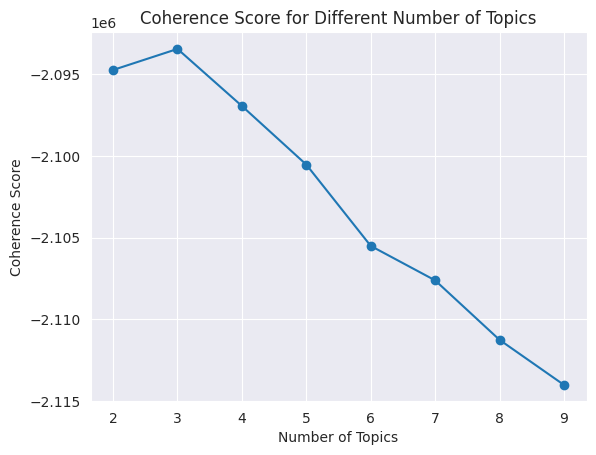

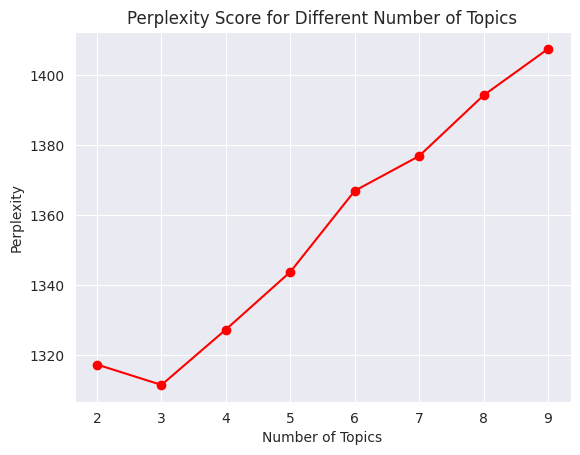

In [22]:
countvectorizer = CountVectorizer(max_features=5000)
data_countvectorized = countvectorizer.fit_transform(data['cleaned_text'])


start, stop, step = 2, 10, 1

compute_coherence_values(countvectorizer, data_countvectorized, start, stop, step)
compute_perplexity_values(countvectorizer, data_countvectorized, start, stop, step)



In [23]:
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(data_countvectorized )


words = countvectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words = [words[j] for j in topic.argsort()[-10:]]
    print(f"Topic {i+1}: {', '.join(top_words)}")

Topic 1: club, lounge, ba, time, food, service, cabin, crew, good, flight
Topic 2: hours, told, would, service, us, london, british, airways, ba, flight
Topic 3: airways, british, food, economy, business, seats, flight, class, seat, ba


## Sentiment Analysis

In [24]:
sia = SentimentIntensityAnalyzer()

data['sentiment_score'] = data['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
data['sentiment'] = data['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

sentiment
positive    2290
negative    1181
neutral       15
Name: count, dtype: int64


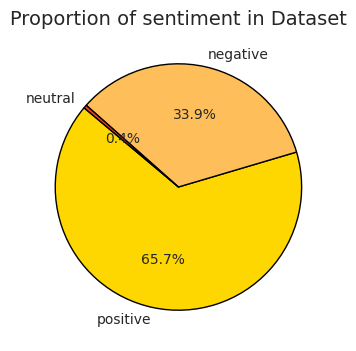

In [25]:
print(data['sentiment'].value_counts())
prop_plot_pie(data,['sentiment'])

In [26]:
data['lexical_diversity'] = data['cleaned_text'].apply(lambda x: len(set(x.split())) / len(x.split()))
print(data[['cleaned_text', 'lexical_diversity']].head())

                                        cleaned_text  lexical_diversity
0  overall bad. staff look tired overworked, tryi...           0.880597
1  first flight british airways 13 years usual co...           0.915254
2  recently encountered highly disappointing expe...           0.835821
3  beware! ba provide refund due serious medical ...           0.807229
4  check chaotic badly organised. even though two...           0.766520


# Fake Review Detection

In [28]:
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(data['cleaned_text'])


n_clusters = 2  #genuine and fake
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(tfidf_matrix)


data['cluster_label'] = labels
data['cluster_label'] = data['cluster_label'].map({0: 'genuine', 1: 'fake'})

cluster_counts = data['cluster_label'].value_counts()
print("Cluster counts:\n", cluster_counts)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster counts:
 cluster_label
genuine    2173
fake       1313
Name: count, dtype: int64


In [29]:
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers = iso_forest.fit_predict(tfidf_matrix)


data['IsoForest_label'] = outliers
data['IsoForest_label'] = data['IsoForest_label'].map({1: 'genuine', -1: 'fake'})


print(data['IsoForest_label'].value_counts())



IsoForest_label
genuine    3137
fake        349
Name: count, dtype: int64


In [30]:
svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
svm.fit(tfidf_matrix)
svm_labels = svm.predict(tfidf_matrix)


data['svm_label'] = np.where(svm_labels == 1, 'genuine', 'fake')


print(data['svm_label'].value_counts())


svm_label
genuine    3117
fake        369
Name: count, dtype: int64


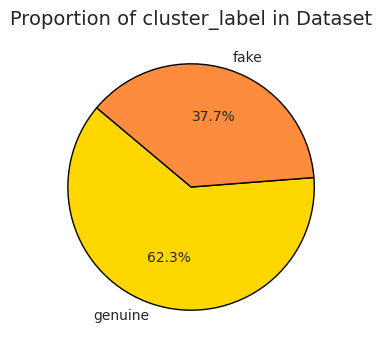

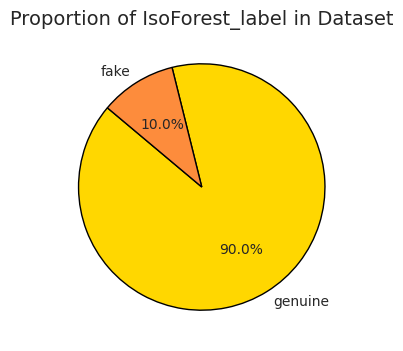

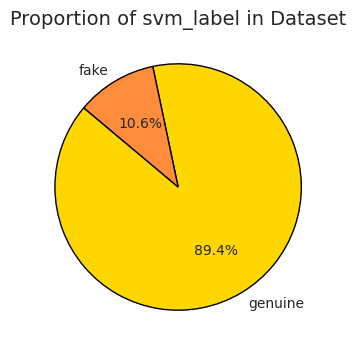

In [31]:
prop_plot_pie(data,['cluster_label','IsoForest_label','svm_label'])

In [32]:
data['agreement'] = (data['cluster_label'] == data['IsoForest_label']) & (data['IsoForest_label'] == data['svm_label'])
agreement_count = data['agreement'].sum()
total_reviews = len(data)
agreement_percentage = (agreement_count / total_reviews) * 100

print(f"Total Reviews: {total_reviews}")
print(f"Number of Reviews with Agreement Across All Methods: {agreement_count}")
print(f"Percentage Agreement: {agreement_percentage:.2f}%")

Total Reviews: 3486
Number of Reviews with Agreement Across All Methods: 1781
Percentage Agreement: 51.09%


## Voting system

In [33]:
data['cluster_binary'] = data['cluster_label'].map({'genuine': 0, 'fake': 1})
data['iso_binary'] = data['IsoForest_label'].map({'genuine': 0, 'fake': 1})
data['svm_binary'] = data['svm_label'].map({'genuine': 0, 'fake': 1})

data['final_label'] = data[['cluster_binary', 'iso_binary', 'svm_binary']].sum(axis=1).apply(lambda x: 'fake' if x >= 2 else 'genuine')

print(data['final_label'].value_counts())



final_label
genuine    3166
fake        320
Name: count, dtype: int64


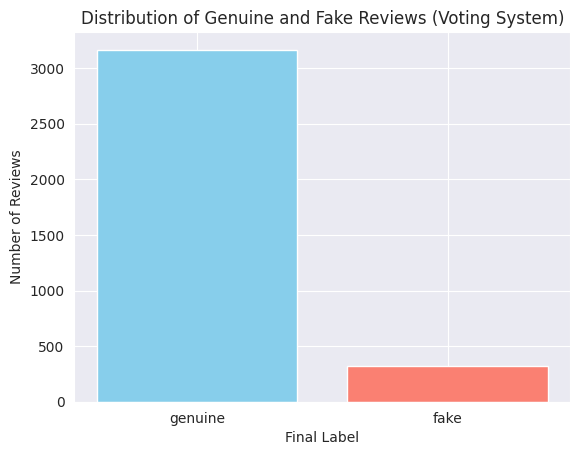

In [34]:
final_counts = data['final_label'].value_counts()
plt.bar(final_counts.index, final_counts.values, color=['skyblue', 'salmon'])
plt.xlabel('Final Label')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Genuine and Fake Reviews (Voting System)')
plt.show()

In [55]:
tmp_fake = data[data['final_label'] == 'fake'].reset_index(drop = True)
tmp_neg = data[data['sentiment'] == 'negative'].reset_index(drop = True)

In [56]:
tmp_fake[["Raw_review",'final_label']]

,Raw_review,final_label
0,Beware! BA don't provide any refund due to a v...,fake
1,Once again a terrible business class experienc...,fake
2,BA is great in the air! But... they sell you c...,fake
3,Booked a flight from Bucharest to Manchester w...,fake
4,"A totally unremarkable flight, on time, as com...",fake
...,...,...
315,CPH-LHR-CPH October 2014. Air travel just keep...,fake
316,I had a very poor experience with BA from Jo'b...,fake
317,LHR-ZRH. A320 was used on this route. I was no...,fake
318,Took BA flight 289 from LHR to PHX 10/27/2014....,fake


In [57]:
tmp_neg[["Raw_review",'final_label']]

,Raw_review,final_label
0,I recently encountered a highly disappointing ...,genuine
1,Beware! BA don't provide any refund due to a v...,fake
2,All 4 of our flights were fine in terms of com...,genuine
3,I was going to fly to Frankfurt from Glasgow o...,genuine
4,Once again a terrible business class experienc...,fake
...,...,...
1176,When will they learn. I flew BA to Dubai last ...,genuine
1177,London to Budapest on Club World-now I don't e...,genuine
1178,BKK-LHR-EDI-LHR-BKK Outbound flight up to stan...,genuine
1179,I have flown twice with BA now in business cla...,genuine


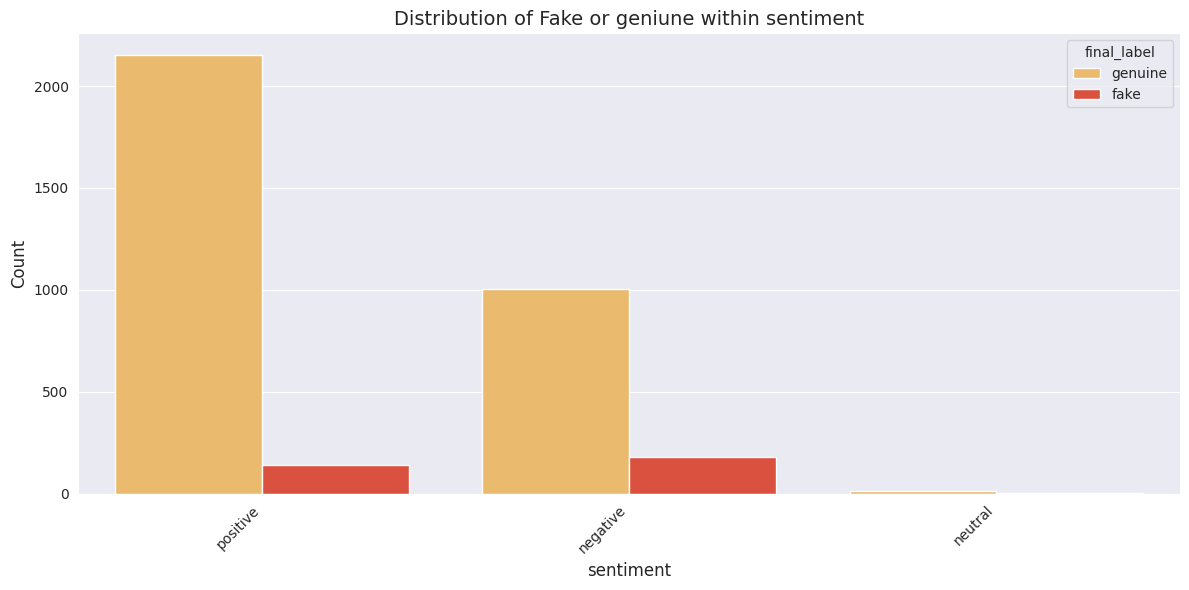

In [66]:
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment', hue='final_label', data=data, palette="YlOrRd")
plt.title(f"Distribution of Fake or geniune within sentiment", fontsize=14)
plt.xlabel('sentiment', fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title='final_label', loc="upper right")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

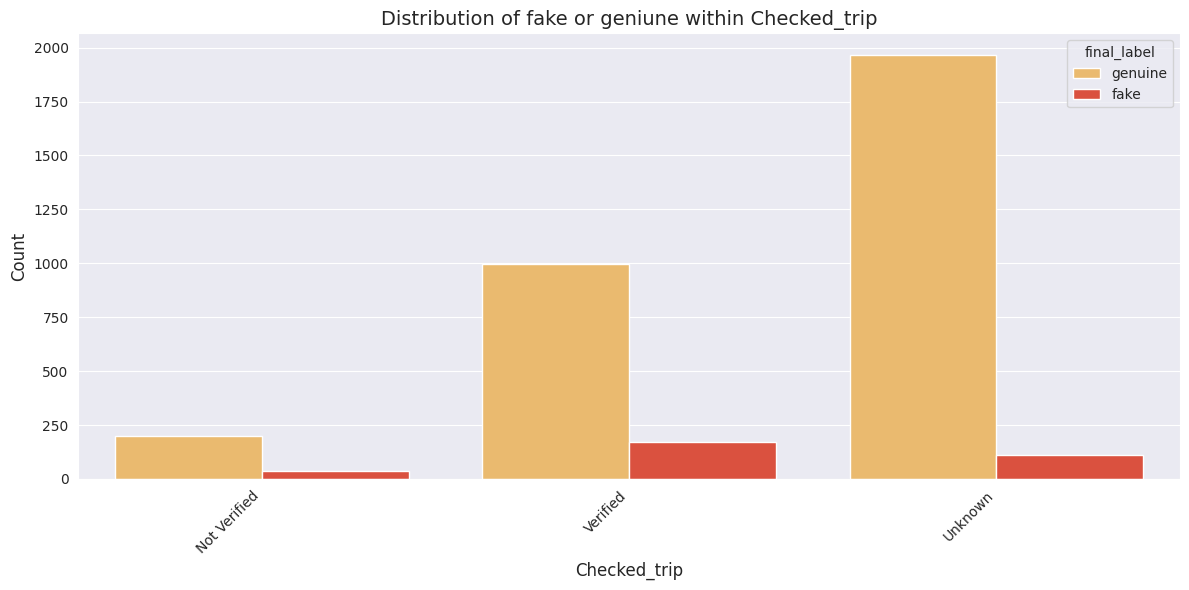

In [67]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Checked_trip', hue='final_label', data=data, palette="YlOrRd")
plt.title(f"Distribution of fake or geniune within Checked_trip", fontsize=14)
plt.xlabel('Checked_trip', fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title='final_label', loc="upper right")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

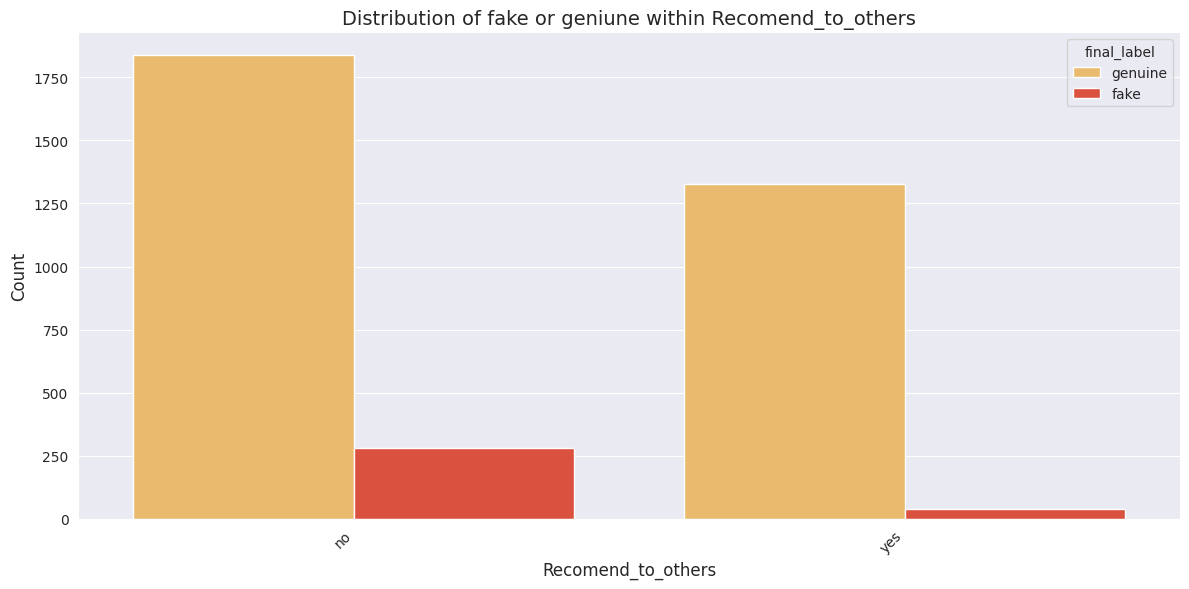

In [69]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Recomend_to_others', hue='final_label', data=data, palette="YlOrRd")
plt.title(f"Distribution of fake or geniune within Recomend_to_others", fontsize=14)
plt.xlabel('Recomend_to_others', fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title='final_label', loc="upper right")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()